In [42]:

from utils.functions import get_path
from preprocessing.image_processing import crop_borders, remove_noise, remove_artifacts, \
    normalize_breast, apply_clahe_transform, flip_breast, pad_image_into_square, resize_img

import cv2
import matplotlib.pyplot as plt
import os


%matplotlib inline

CONVERTED_DATA_PATH = get_path(os.path.abspath(os.getcwd()), 'TFM', 'Code', 'data', '01_CONVERTED')

In [38]:
img_path = get_path(CONVERTED_DATA_PATH, 'MIAS', 'BENIGN', 'FULL', 'mdb005.png')
mask_path_0 = get_path(CONVERTED_DATA_PATH, 'MIAS', 'BENIGN', 'MASK', 'mdb005_0.png')
mask_path_1 = get_path(CONVERTED_DATA_PATH, 'MIAS', 'BENIGN', 'MASK', 'mdb005_1.png')


img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
img_mask = cv2.cvtColor(cv2.imread(mask_path_0), cv2.COLOR_BGR2GRAY) + cv2.cvtColor(cv2.imread(mask_path_1), cv2.COLOR_BGR2GRAY)

In [39]:
# Se dibuja un círculo alrededor de la imagen dónde hay las patologías
cv2.circle(img, (477, 1024 - 133), 30, (255, 255, 255))
cv2.circle(img, (500, 1024 - 168), 26, (255, 255, 255))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

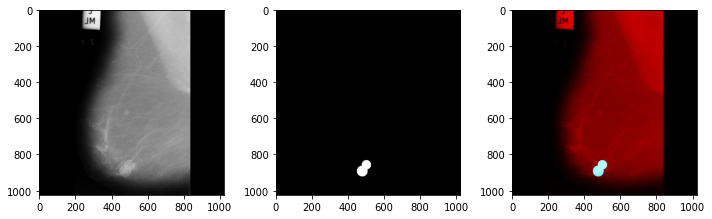

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(img_mask, cmap='gray')
ax[2].imshow(cv2.merge([img, img_mask, img_mask]))

fig.tight_layout()


In [49]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
img_mask = cv2.cvtColor(cv2.imread(mask_path_0), cv2.COLOR_BGR2GRAY) + cv2.cvtColor(cv2.imread(mask_path_1), cv2.COLOR_BGR2GRAY)

images = {'ORIGINAL': img}

# Primero se realiza un crop de las imagenes en el caso de que sean imagenes completas
images['CROPPING 1'] = crop_borders(
    images[list(images.keys())[-1]].copy(), **{'left': 0.01, 'right': 0.01, 'top': 0.04, 'bottom': 0.04})

# Se aplica el mismo procesado a la mascara
img_mask = crop_borders(img_mask, **{'left': 0.01, 'right': 0.01, 'top': 0.04, 'bottom': 0.04})

# A posteriori se quita el ruido de las imagenes utilizando un filtro medio
images['REMOVE NOISE'] = remove_noise(img=images[list(images.keys())[-1]].copy(), **{'ksize': 3})

In [50]:
# El siguiente paso consiste en eliminar los artefactos de la imagen. Solo aplica a imagenes completas
images['REMOVE ARTIFACTS'], _, _, mask, img_mask = remove_artifacts(
    img=images[list(images.keys())[-1]].copy(), mask=img_mask, **{
            'bin_kwargs': {'thresh': 'constant', 'threshval': 30},
            'mask_kwargs': {'kernel_shape': cv2.MORPH_ELLIPSE, 'kernel_size': (20, 10), 'operations': [(cv2.MORPH_OPEN, None), (cv2.MORPH_DILATE, 2)]},
            'contour_kwargs': {'convex_contour': False}
        }
)

# Una vez eliminados los artefactos, se realiza una normalización de la zona del pecho
images['IMAGE NORMALIZED'] = normalize_breast(images[list(images.keys())[-1]].copy(), mask, **{'type_norm': 'min_max'})


images['IMG_SYNTETIZED'] = apply_clahe_transform(img=images[list(images.keys())[-1]].copy(), mask=mask, **{'clahe_1': {'clip': 2}})

# Se realiza el flip de la imagen en caso de ser necesario:
images['IMG_FLIP'], flip = flip_breast(images[list(images.keys())[-1]].copy(), **{'orient': 'left'})

if flip:
    img_mask = cv2.flip(src=img_mask, flipCode=1)

# Se aplica el ultimo crop de la parte izquierda
# Primero se realiza un crop de las imagenes
images['CROPPING LEFT'] = crop_borders(images[list(images.keys())[-1]].copy(), **{'left': 0.05, 'right': 0, 'top': 0, 'bottom': 0})
img_mask = crop_borders(img=img_mask,  **{'left': 0.05, 'right': 0, 'top': 0, 'bottom': 0})

# Se aplica el padding de las imagenes para convertirlas en imagenes cuadradas
images['IMAGE PADDED'] = pad_image_into_square(img=images[list(images.keys())[-1]].copy())
img_mask = pad_image_into_square(img=img_mask)

# Se aplica el resize de la imagen:
images['IMAGE RESIZED'] = resize_img(img=images[list(images.keys())[-1]].copy(), **{'size': 1024})
img_mask = resize_img(img=img_mask, **{'size': 1024})

ValueError: not enough values to unpack (expected 5, got 4)